# Notebook for Model Experimentation:
1. Going to begin by trying simple clustering techniques to see if the data clusters conveniently, will probably fail

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# shows all columns and all rows if you print the df
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", None)

In [267]:
df = pd.read_csv("../data/data_unzipped/netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


# Preprocess Data and Replace Missing Values

In [268]:
df.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [269]:
#convert date column:
df['date'] = df['date_added'].str.strip()
df['date'] = pd.to_datetime(df['date'])

df_date = df.sort_values(by='date', ascending=False).reset_index(drop=True)
df.dropna(subset='date', inplace=True)

df.drop(columns='date_added', inplace=True)

In [270]:
cols_to_manually_fill = ['director', 'cast']

#filling director and cast with N/A, dont really have an imputing strategy here:
df[cols_to_manually_fill] = df[cols_to_manually_fill].fillna("N/A")

In [271]:
from sklearn.impute import SimpleImputer

cols_to_impute = ['country', 'rating', 'duration']
imputer = SimpleImputer(strategy="most_frequent")
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

In [272]:
df.isna().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
release_year    0
rating          0
duration        0
listed_in       0
description     0
date            0
dtype: int64

In [273]:
df.head()

,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description,date
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,N/A,United States,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021-09-25
1,s2,TV Show,Blood & Water,N/A,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021-09-24
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",United States,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021-09-24
3,s4,TV Show,Jailbirds New Orleans,N/A,N/A,United States,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021-09-24
4,s5,TV Show,Kota Factory,N/A,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021-09-24


# Now to engineer some features from what we have

In [274]:
# easy ones:

#for idempotency, makes every cell infinitely re-runnable
df_engineered = df.copy()

#description kinda useless tbh
df_engineered = df_engineered.drop(columns="description")

#rename for ease of use
df_engineered = df_engineered.rename(columns={"listed_in":"genre"})

# grab the year on its own
df_engineered['year_added'] = df_engineered['date'].dt.year

In [275]:
"""
Here I am just exploding out the columns that have tons of comma separated values
"""
def explode_column(df, column):
    df_exploded = df[column].str.strip().str.split(",", expand=True)
    num_columns = df_exploded.shape[1]
    column_names = [f"{column}-{i}" for i in range(0, num_columns)]
    df_exploded.columns = column_names
    return df_exploded

#drop original country column:

df_countries_exploded = explode_column(df_engineered, "country")
df_cast_exploded = explode_column(df_engineered, "cast")
df_genre_exploded = explode_column(df_engineered, "genre")

In [276]:
"""
Bring them all together, its a little cumbersome but it works:
"""
df_concat = pd.concat([df_engineered, df_countries_exploded, df_cast_exploded, df_genre_exploded], axis=1)
df_concat = df_concat.fillna("N/A")
df_concat = df_concat.drop(columns=['country', 'director', 'cast', 'genre'])
df_concat.head(2)

,show_id,type,title,release_year,rating,duration,date,year_added,country-0,country-1,country-2,country-3,country-4,country-5,country-6,country-7,country-8,country-9,country-10,country-11,cast-0,cast-1,cast-2,cast-3,cast-4,cast-5,cast-6,cast-7,cast-8,cast-9,cast-10,cast-11,cast-12,cast-13,cast-14,cast-15,cast-16,cast-17,cast-18,cast-19,cast-20,cast-21,cast-22,cast-23,cast-24,cast-25,cast-26,cast-27,cast-28,cast-29,cast-30,cast-31,cast-32,cast-33,cast-34,cast-35,cast-36,cast-37,cast-38,cast-39,cast-40,cast-41,cast-42,cast-43,cast-44,cast-45,cast-46,cast-47,cast-48,cast-49,genre-0,genre-1,genre-2
0,s1,Movie,Dick Johnson Is Dead,2020,PG-13,90 min,2021-09-25,2021,United States,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,Documentaries,N/A,N/A
1,s2,TV Show,Blood & Water,2021,TV-MA,2 Seasons,2021-09-24,2021,South Africa,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,Ama Qamata,Khosi Ngema,Gail Mabalane,Thabang Molaba,Dillon Windvogel,Natasha Thahane,Arno Greeff,Xolile Tshabalala,Getmore Sithole,Cindy Mahlangu,Ryle De Morny,Greteli Fincham,Sello Maake Ka-Ncube,Odwa Gwanya,Mekaila Mathys,Sandi Schultz,Duane Williams,Shamilla Miller,Patrick Mofokeng,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,International TV Shows,TV Dramas,TV Mysteries


# Analyze `type`, Movies vs. TV Show

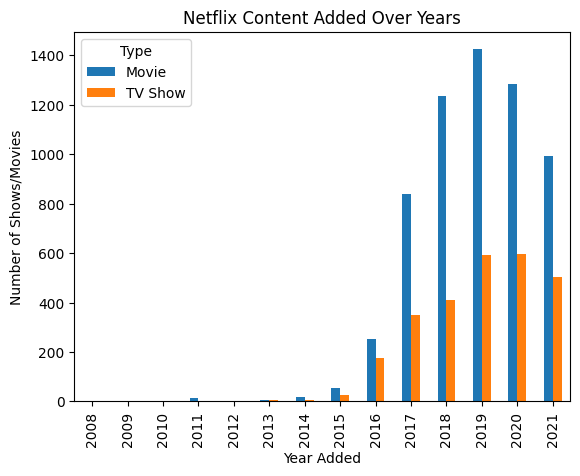

In [277]:
year_type_counts = df_concat.groupby(['year_added', 'type']).size().unstack(fill_value=0)

#significantly more movies than tv shows added to netflix over time
year_type_counts.plot(kind='bar', stacked=False)
plt.title('Netflix Content Added Over Years')
plt.xlabel('Year Added')
plt.ylabel('Number of Shows/Movies')
plt.legend(title='Type')
plt.show()

In [351]:
"""
Aggregates counts for an exploded column in the dataframe by year.

Parameters:
df (DataFrame): The source dataframe.
column (str): The base name of the exploded column.

Returns:
DataFrame: Yearly counts of the shows/movies for each category in the exploded column.
DataFrame: Total counts for each category in the exploded column across all years.
"""
def counts_per_exploded_column(df, column):
    valid_cols = [col for col in df.columns if col.startswith(f"{column}-")]
    df_melted = df.melt(id_vars=['show_id', 'year_added', 'type'], value_vars=valid_cols, var_name=f'{column}-var', value_name=f"{column}")
    df_melted[column] = df_melted[column].str.strip()
    
    #remove duplicates and get the show/movie counts by country
    df_melted.drop_duplicates(subset=['show_id', f"{column}"], inplace=True)
    column_year_counts = df_melted.groupby(['year_added', f"{column}"]).size().unstack(fill_value=0)
    total_counts_per_column = column_year_counts.sum(axis=0)

    return column_year_counts, total_counts_per_column

# Analyze `country`:

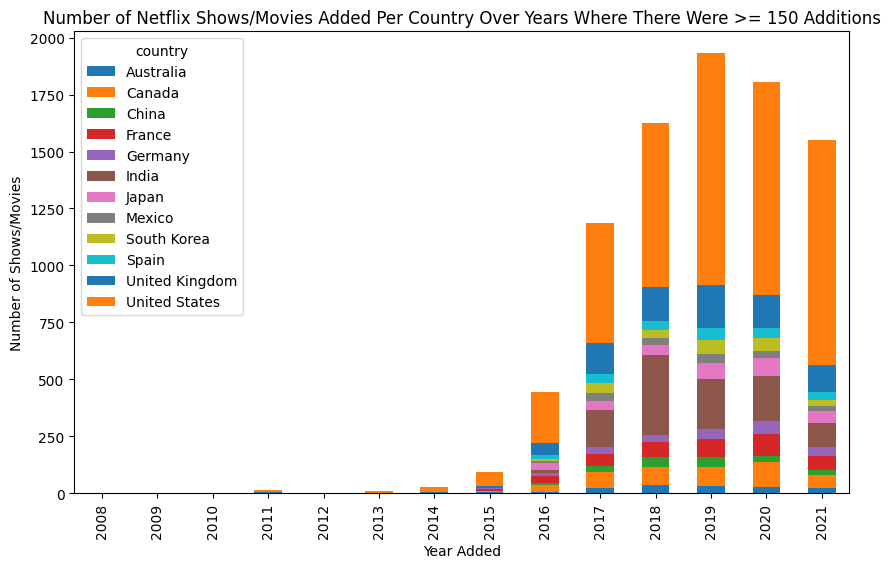

In [356]:
#filter by countries that actually place so this figure works lol
country_year_counts, total_counts_per_country = counts_per_exploded_column(df_concat, "country")

"""
Logic below for plotting and setting arbitrary threshold, with no threshold the plot just kind of explodes because theres too much information:
"""

threshold = 150

filtered_countries = total_counts_per_country[total_counts_per_country > threshold].index.tolist()

filtered_countries = [country for country in filtered_countries if country!="N/A"]

#filter by these countries with >=50 shows/movies per year
filtered_country_year_counts = country_year_counts[filtered_countries]

filtered_country_year_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title(f'Number of Netflix Shows/Movies Added Per Country Over Years Where There Were >= {threshold} Additions')
plt.xlabel('Year Added')
plt.ylabel('Number of Shows/Movies')
plt.show()

# Analyze `genre`: 

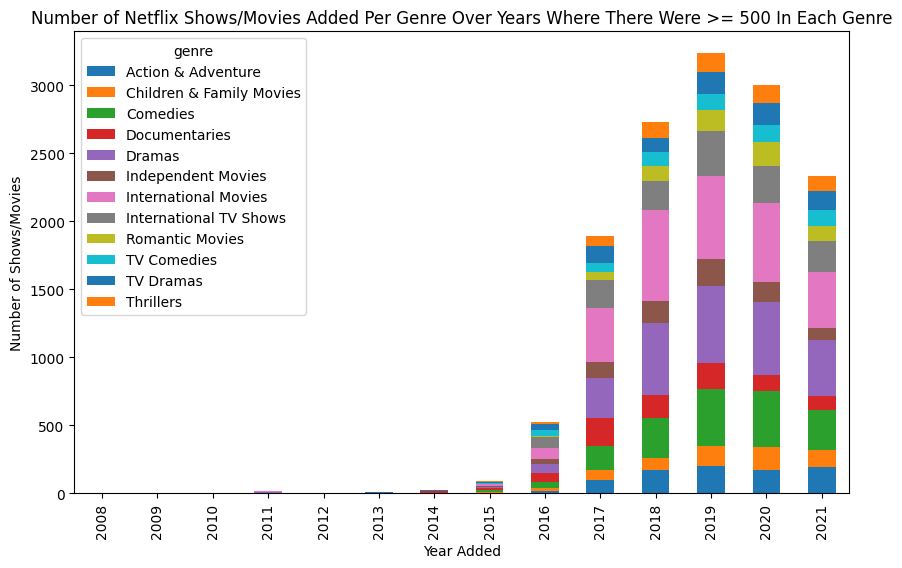

In [357]:
genre_year_counts, total_counts_per_genre = counts_per_exploded_column(df_concat, "genre")

threshold = 500

filtered_genres = total_counts_per_genre[total_counts_per_genre > threshold].index.tolist()

filtered_genres = [val for val in filtered_genres if val!="N/A"]

#filter by these countries with >=50 shows/movies per year
filtered_genre_year_counts = genre_year_counts[filtered_genres]

filtered_genre_year_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title(f'Number of Netflix Shows/Movies Added Per Genre Over Years Where There Were >= {threshold} In Each Genre')
plt.xlabel('Year Added')
plt.ylabel('Number of Shows/Movies')
plt.show()

# Analyze `cast`:

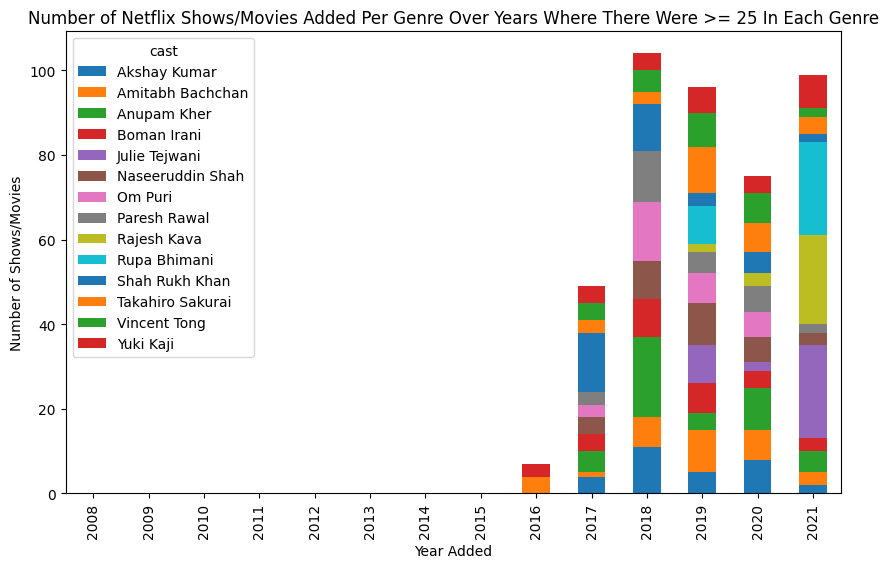

In [371]:
"""
So the most common actors are absolutely from India no doubt:
"""

cast_year_counts, total_counts_per_castmember = counts_per_exploded_column(df_concat, "cast")

threshold = 25

filtered_cast = total_counts_per_castmember[total_counts_per_castmember > threshold].index.tolist()

filtered_cast = [val for val in filtered_cast if val!="N/A"]

#filter by these countries with >=50 shows/movies per year
filtered_cast_year_counts = cast_year_counts[filtered_cast]

filtered_cast_year_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title(f'Number of Netflix Shows/Movies Added Per Genre Over Years Where There Were >= {threshold} In Each Genre')
plt.xlabel('Year Added')
plt.ylabel('Number of Shows/Movies')
plt.show()

# Play around with subscriber data:

In [373]:
df_subscriber = pd.read_csv("../data/netflix_sub_count.csv")

In [384]:
df_subscriber = df_subscriber.groupby("Year").sum().reset_index()

In [385]:
df_subscriber

,Year,Quarter,Subscriptions (millions)
0,2013,Q1Q2Q3Q4,149.32
1,2014,Q1Q2Q3Q4,199.25
2,2015,Q1Q2Q3Q4,258.56
3,2016,Q1Q2Q3Q4,329.98
4,2017,Q1Q2Q3Q4,408.06
5,2018,Q1Q2Q3Q4,512.93
6,2019,Q1Q2Q3Q4,625.84
7,2020,Q1Q2Q3Q4,774.62
8,2021,Q1Q2Q3Q4,852.22


In [387]:
plt.plot(df_subscriber['Year'], df_subscriber['Subscriptions (millions'])

SyntaxError: positional argument follows keyword argument (1204978234.py, line 1)